# Autoregression models for forecasting indoor air quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from statsmodels.graphics.tsaplots import plot_acf

print(os.getcwd())

/home/charlie/Documents/Uni/Exeter - Data Science/MTHM604_Tackling_Sustainability_Challenges/MTHM604_week_12/MTHM604_week_1/code


### Import data

In [2]:
dataDir = "../data"

In [3]:
df = pd.read_csv(f"{dataDir}/cleanData/indoorAq/ts_0011_sid6322070.csv")
                 #Weekend trends #ts_0109_sid6322115.csv")
                 #weekday trend #ts_0118_sid6322122.csv")
                 
                 #ts_0007_sid6321576.csv")
                 
                 #ts_0111_sid6322117.csv")



In [4]:
df.head()

,Unnamed: 0,datetime,PM2_5,sid,uprns,sensType
0,0,2018-01-01 00:01:00,24.0,6322070,11,IN
1,1,2018-01-01 00:07:00,24.0,6322070,11,IN
2,2,2018-01-01 00:12:00,15.0,6322070,11,IN
3,3,2018-01-01 00:17:00,17.0,6322070,11,IN
4,4,2018-01-01 00:27:00,13.0,6322070,11,IN


In [5]:
df.isnull().sum()

Unnamed: 0    0
datetime      0
PM2_5         0
sid           0
uprns         0
sensType      0
dtype: int64

In [6]:
df2 = df.drop(columns = ["Unnamed: 0", "sid", "uprns", "sensType"])

In [7]:
df2.dtypes

datetime     object
PM2_5       float64
dtype: object

In [8]:
df2['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
df2.head()

,datetime,PM2_5
0,2018-01-01 00:01:00,24.0
1,2018-01-01 00:07:00,24.0
2,2018-01-01 00:12:00,15.0
3,2018-01-01 00:17:00,17.0
4,2018-01-01 00:27:00,13.0


In [10]:
# Add day and month name
df2['dayname'] = df2['datetime'].apply(lambda x: x.dayofweek)
df2['month'] = df2['datetime'].apply(lambda x: x.month)
df2['dayofyear'] = df2['datetime'].apply(lambda x: x.dayofyear)



In [11]:
# Calulate overall mean
y_mean = df2['PM2_5'].mean()
df2['y_norm'] = df2['PM2_5']-y_mean




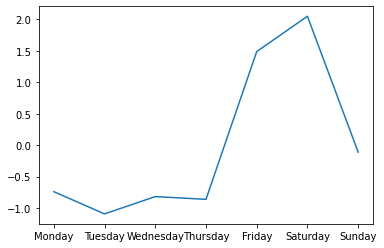

In [12]:
# Plot weekday trend
days_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
            }
df_day = df2.groupby("dayname", as_index = False).mean()
df_day = df_day.sort_values(by = ['dayname'], axis = 0, ascending = True)
df_day['dayname2'] = df_day['dayname'].apply(lambda x: days_dict[x])
plt.plot(df_day['dayname2'],df_day['y_norm'])

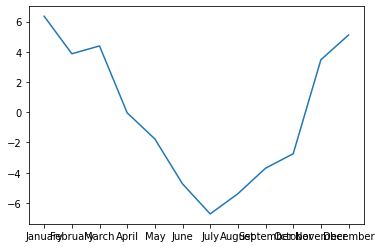

In [161]:
month_dict = {
    1:"January",
    2:"February",
    3:"March",
    4:"April",
    5:"May",
    6:"June",
    7:"July",
    8:"August",
    9:"September",
    10:"October",
    11:"November",
    12:"December"
}

#Plot monthly trend
df_month = df2.groupby("month", as_index = False).mean()
df_month = df_month.sort_values(['month'],axis = 0, ascending = True)
df_month['month2'] = df_month['month'].apply(lambda x: month_dict[x])
plt.plot(df_month['month2'],df_month['y_norm'])


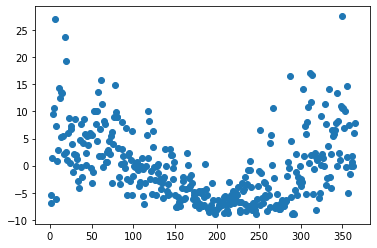

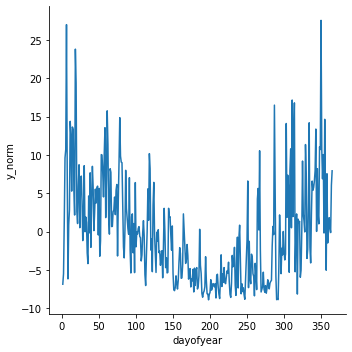

In [113]:
#Plot monthly trend
df3 = df2.groupby("dayofyear").mean()
df3 = df3.sort_index(axis = 0, ascending = True)
plt.scatter(df3.index,df3['y_norm'])
import seaborn as sns
sns.relplot(
    data=df3, x="dayofyear", y="y_norm", kind="line"
)

## Plot data as time series

In [ ]:
fig = plt.figure(figsize = (15,7))
plt.plot(df2.set_index('datetime'))

## Autocorrelation of data

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df2.set_index('datetime').iloc[0:50,:])
plt.show()

## Auto regression model

In [ ]:

df2 = df2.set_index('datetime')
df2.index = pd.DatetimeIndex(df2.index).to_period('T')
X = df2
X

In [ ]:
split =round(len(X)*0.2)
train, test = X[1:(len(X)-split)], X[(len(X)-split):]

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

model = AutoReg(train, lags = 10)
model_fit = model.fit()
coef = model_fit.params

In [ ]:
coef

In [ ]:
# walk forward over time steps in test
window = 10
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
print('Test RMSE: %.3f' % rmse)

## Arima Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(train, order = (10, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

### Plot residuals

In [ ]:

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [ ]:
residuals.plot(kind='kde')
plt.show()

In [ ]:
print(residuals.describe())

## Rolling forecast

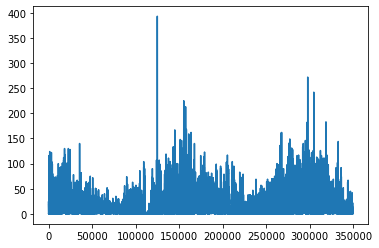

In [25]:
from statsmodels.tsa.arima.model import ARIMA

df3 = df2.set_index('datetime')
df3.index = pd.DatetimeIndex(df3.index).to_period('T')
X = df3['PM2_5'].dropna().squeeze()
size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = list()
plt.plot(train.values)

In [15]:
for t in range(len(test)):
    model = ARIMA(history, order = (5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted = %f, expected = %f' % (yhat, obs))
    

predicted = 1.000000, expected = 1.000000
predicted = 1.000000, expected = 1.000000


KeyboardInterrupt: 

In [ ]:
rmse = 

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('../shampoo.csv', header=0, index_col=0, parse_dates=True, squeeze=False, date_parser=parser)
series.index = series.index.to_period('M')

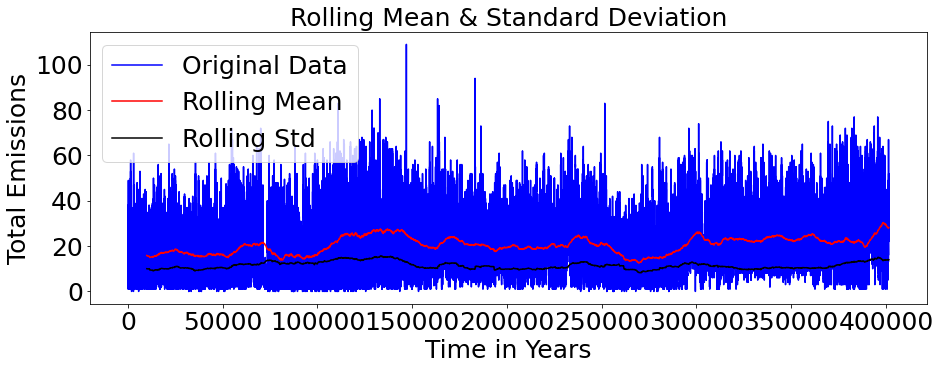

In [12]:


import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 10000, center = False).mean()
    rol_std = ts.rolling(window = 10000, center = False).std()

    fig = plt.figure(figsize = [15, 5])
    plt.plot(ts.values, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean.values, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std.values, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

TestStationaryPlot(df3)



In [ ]:


def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

TestStationaryAdfuller(df3)